In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import matplotlib.pyplot as plt

## Loading the data

In [2]:
# Load the data

df = pd.read_stata('data/PisoFirme_AEJPol-20070024_household.dta')
df.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


In [3]:
# Define the group durango (the control group of the original paper)
durango = df[df.dpisofirme == 0]

Now we will define the control and treatment group for our experiment. We consider only households which were not proposed Piso Firme (durango). The new treatment group will be households which installed cement floors (S_instcement = 1) by themselve, the new control group will be people who did not install cement floors (S_instcement = 0).

<AxesSubplot:>

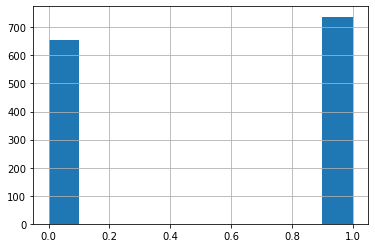

In [4]:
# Plot
durango.S_instcement.hist()

We can see that the two groups are balanced.

## Matching

### Propensity scores computation

In [5]:
# Standardize continuous features

# Define variables for propensity scores (economic variables that could influence installation of cement)

propensity_variables = ['S_incomepc','S_assetspc','S_shpeoplework','S_hrsworkedpc',
                        'S_consumptionpc','S_cashtransfers']

In [6]:
durango = durango.dropna(subset=['S_instcement', 'S_incomepc','S_assetspc','S_shpeoplework','S_hrsworkedpc',
                        'S_consumptionpc','S_cashtransfers'])

durango[propensity_variables]

,S_incomepc,S_assetspc,S_shpeoplework,S_hrsworkedpc,S_consumptionpc,S_cashtransfers
0,1108.333374,35087.679688,0.333333,16.666666,704.000000,0.0
1,1000.000000,53054.988281,0.500000,24.000000,934.250000,0.0
2,1100.000000,52930.226562,0.500000,15.000000,934.140015,0.0
3,660.416687,30632.578125,0.250000,12.000000,324.750000,0.0
4,0.000000,21158.214844,0.000000,0.000000,259.799988,0.0
...,...,...,...,...,...,...
1388,400.000000,20729.542969,0.200000,9.600000,643.099976,0.0
1389,949.714294,15572.803711,0.285714,18.714285,494.519989,0.0
1390,608.000000,20948.089844,0.200000,2.000000,539.599976,64.0
1391,821.777771,35472.132812,0.333333,12.000000,770.433350,0.0


In [28]:
durango.S_instcement.unique()

array([0., 1.])

In [9]:
# Standardize variables used for propensity scores

for v in propensity_variables:
    durango[v] = (durango[v] - durango[v].mean())/durango[v].std()
    
durango[propensity_variables].head()

,S_incomepc,S_assetspc,S_shpeoplework,S_hrsworkedpc,S_consumptionpc,S_cashtransfers
0,0.026686,1.783805,0.572386,0.294665,-0.040731,-0.349656
1,-0.001264,4.238541,1.882376,1.139142,0.147881,-0.349656
2,0.024536,4.221496,1.882376,0.102739,0.147791,-0.349656
3,-0.088875,1.175139,-0.082609,-0.242729,-0.351397,-0.349656
4,-0.259259,-0.119271,-2.047593,-1.624600,-0.404601,-0.349656


In [10]:
# Build the model

mod = smf.logit(formula='S_instcement ~  S_incomepc + S_assetspc + S_shpeoplework + S_hrsworkedpc \
                + S_consumptionpc + S_cashtransfers', data=durango)

res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.681915
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           S_instcement   No. Observations:                 1388
Model:                          Logit   Df Residuals:                     1381
Method:                           MLE   Df Model:                            6
Date:                Thu, 10 Dec 2020   Pseudo R-squ.:                 0.01360
Time:                        15:42:51   Log-Likelihood:                -946.50
converged:                       True   LL-Null:                       -959.54
Covariance Type:            nonrobust   LLR p-value:                 0.0002139
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1296      0.055      2.364      0.018       0.022       0.237
S_incomepc    

In [11]:
# Compute the propensity scores

durango['propensity_score'] = res.predict()

In [12]:
# Define control and treatment groups
treatment = durango[durango.S_instcement == 1]
control = durango[durango.S_instcement == 0]

In [13]:
# Function to compute similarity from two propensity scores
def get_similarity(ps1, ps2):
    return 1-np.abs(ps1 - ps2)

In [14]:
# Matching step using our computed propensity scores

# Create an undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treatment.iterrows():
    for control_id, control_row in control.iterrows():
        
        # Calculate the similarity 
        similarity = get_similarity(control_row['propensity_score'],
                                     treatment_row['propensity_score'])
        
        # take epsilon = 0.05 as a threshold for matching
        if similarity > 0.95:
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [30]:
# put the balanced pairs of papers into one dataframe
match_0 = durango.loc[pd.DataFrame(matching)[0]]
match_1 = durango.loc[pd.DataFrame(matching)[1]]
durango_match = pd.concat([match_0,match_1])

# report the number of pairs
print("The number of matched pairs is {}, and the number of unmatched ones is {}.".format(len(match_0),\
                                                                                     len(treatment)-len(match_0)))

The number of matched pairs is 650, and the number of unmatched ones is 86.
